# Muawiya Funcs

In [37]:
import cv2
import mediapipe as mp
import numpy as np
import math
import datetime
import pandas as pd
import os 
import pickle
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import wait


#### Calculate Angle Between Three Point (1.shoulder,2.elbow,3.wrist)

In [38]:
def calculate_angle(SHOULDER,ELBOW,WRIST):
    """
    _ calculate_angle:Function to calculate angle between three point (1.shoulder,2.elbow,3.wrist)
    _ shoulder:pose landmark number 11 and 12 containe X_position and Y_position
    _ elbow:pose landmark number 13 and 14 containe X_position and Y_position
    _ wrist:pose landmark number 15 and 16 containe X_position and Y_position
    """
    SHOULDER = np.array(SHOULDER) # First
    ELBOW = np.array(ELBOW) # Mid
    WRIST = np.array(WRIST) # End
    

#     https://www.medcalc.org/manual/atan2-function.php
    radians = np.arctan2(WRIST[1]-ELBOW[1] , WRIST[0]-ELBOW[0]) - np.arctan2(SHOULDER[1]-ELBOW[1] , SHOULDER[0]-ELBOW[0] )
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180:
        angle = 360-angle
    return angle

#### filtter Points in Curent Frame 

In [39]:
def filtter_points(landmark_1):
    """
    _ filtter_points:Function to fillter all points in specific landmark (shoulder,elbow,wrist,hip,knee,ankle "_left&right_")
    _ landmark_1:pose landmark for curent frame
    """
    my_list = []
    for ind in range(len(landmark_1)):
        if ((ind>0)and(ind<=10))or((ind>=17)and(ind<=32)):
            continue
        p1 = [landmark_1[ind].x,landmark_1[ind].y]
        my_list.append(np.array([[p1[0]],[p1[1]]]))
    return my_list

#### Kalman Filter Equation Prediction Update 

In [40]:
def Prediction_update(X,A,P,Q):
    """
    _ Prediction_update:Function to Applying Prediction Equation
    _ X:State Matrix [X_position,Y_position,X_velocity,Y_velocity]
    _ A:State Transition
    _ P:Process Covariance Matrix
    _ Q:Erorr Terms
    """
    X = A.dot(X)
    TEPM = A.dot(P)
    P = TEPM.dot(A.T)+Q
    return X,P

##### Kalman Filter Equation Measurement Update

In [41]:
def Measurement_update(Z,X,P,H,R):
    """
    _ Measurement_update:Function to Applying Measurement Equation
    _ X:State Matrix [X_position,Y_position,X_velocity,Y_velocity]
    _ P:Process Covariance Matrix
    _ H:unit matrix
    _ R:Erorr Terms of the Measurement
    """
    I = np.array([[1,0],
                  [0, 1]])
    
    T1 = P.dot(H.T)
    T2 = H.dot(P)
    T3 = T2.dot(H.T)
    T3 = T3 + R
    K = T1.dot(np.linalg.inv(T3))
    
    T1 = H.dot(X)
    T2 = Z - T1
    T3 = K.dot(T2)
    X = X + T3
    
    T1 = K.dot(H)
    T2 = I - T1
    P = T2.dot(P)

    return X,P,K

#### get all video in any root path

In [42]:
def get_videos(path_folder):
    """
    _ get_videos:Function to get all videos in root path
    _ input:(path_folder) the root path for all dirctory that contant video
    _ output:(folders) all dirctory in root path (all_video_paths) all paths video
    """
    folders = os.listdir(path_folder)
    all_video_paths = []
    for folder in folders:
        curr_dataset_path = os.path.join(path_folder, folder)
        try:
            videos = os.listdir(curr_dataset_path)
        except:
            if ".mp4" in curr_dataset_path:
                all_video_paths.append(curr_dataset_path)
                continue
            else:
                continue
        for video_p in videos:
            all_video_paths.append(os.path.join(curr_dataset_path, video_p))
    return folders , all_video_paths

#### Calculate Average for List or Array of Numbers

In [43]:
def Average(lst):
    """
    _Average:Function to calculate mean for list or array
    _input:List or array of numbers
    _output:the mean for input numbre
    """
    return sum(lst) / len(lst)

#### Save any Object We Need 

In [44]:
def save_object(obj, filename):
    """
    _save_object:Function to save any object
    _input:(obj) the object that we want save , (filename) Memorization path 
    """
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

#### Save any Object

In [45]:
def load_object(filename):
    """
    _load_object:Function to load any object
    _input:object path 
    _output:the object
    """
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

#### calculate angles between shoulder and elbow and wrist point for left and right hand

In [46]:
def calculate_left_right_arm_angle(X):
    """
    _ calculate_left_right_arm_angle:Function to calculate angle between three points from arm 
    _ input: (landmarks) all pose points , (mp_pose) contante all landmark name
    _ output: left and right angle for tow arm
    """
    LEFTangle = calculate_angle([X[1][0][0],X[1][1][0]],[X[3][0][0],X[3][1][0]],[X[5][0][0],X[5][1][0]])
    RIGHTangle = calculate_angle([X[2][0][0],X[2][1][0]],[X[4][0][0],X[4][1][0]],[X[6][0][0],X[6][1][0]])
    return LEFTangle,RIGHTangle

#### Check if ram is moving or not

In [47]:
def check_hand_moving(pre_angle,cur_angle): #####
    """
    _ check_hand_moving: Function to check if arm moving or not 
    _ input: (pre_angle) angle from previose frame (cur_angle) angle from curent frame
    _ output: (True) if arm moving (False) if arm not moving 
    """
    angle = cur_angle-pre_angle
    stage=False
    if angle>5:
        stage = True
    return stage

#### give the results of the calculation

In [48]:
def hand_get_decistion(l_is_moved,r_is_moved):  #####
    """ 
    _ hand_get_decistion: get decis
    _ input: ("l_is_moved") true if left arm is moved or false if not , ("r_is_moved") true if right arm is moved or false if not
    _ output: (Moving Hand , 1) or (Rest Hand 0)
    """
    if l_is_moved or r_is_moved:
        return "Moving Hand",1
    return "Rest Hand",0

In [49]:
def Drawing_utils(image,results,mp_pose):
    """
    _To draw joint points on the image
    """
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66),thickness=4,circle_radius=2),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=4))

In [50]:
def creat_kalman_parameters(delta_t):
    A = np.array([[1, delta_t],[0, 1]]) # STATE MATRIC (The relationship between system variables in the equations of motion)
    P = np.eye(2)*10 # Guess Kalmen , Uncertainty Matrix , The relationship of state variables , external forces
    H = np.eye(2) # Measurement matrix is used to calculate Calmen error
    R = np.eye(2)*0.05 # Noise added for update
    Q =np.eye(2)*0.1 # Noise added for measurement
    X = [np.array([[0], [0]]) for _ in range(7)]
    return A,P,H,R,Q,X

In [51]:
def dist(p1,p2):
    return math.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)

In [52]:
def check_body_moving(i,head_points,elbo_points):
    """
    _To check whether the presenter's body has moved or turned
    """
    if (head_points[-1]<elbo_points[-2][1]) or (head_points[-1]>elbo_points[-2][0]):
        return True
    if (elbo_points[-2][0]-elbo_points[-2][1])>(elbo_points[-1][0]-elbo_points[-1][1]):
        return True
    return False

#### Download the video, perform the required calculations, and then save result

In [53]:
def body(X,head_points,elbo_points,temp,index):
    """
    _Gives the final decision regarding body movement
    """
    NOSE = X[0][0][0]
    LEFT_SHOULDER = X[1][0][0]
    RIGHT_SHOULDER = X[2][0][0]
    
    if NOSE and temp<2:
        head_points.append(NOSE)
        elbo_points.append([LEFT_SHOULDER,RIGHT_SHOULDER])
        temp+=1
    
    if len(head_points)>=1:
        head_points.append(NOSE)
        
        if check_body_moving(index,head_points,elbo_points):
            elbo_points.append([LEFT_SHOULDER,RIGHT_SHOULDER])
            decistion_body,Ndecistion_body = "Moving Body",1
        else:
            decistion_body,Ndecistion_body = "Rest Body",0
    return decistion_body,Ndecistion_body

In [54]:
def hand(X,freeLEFT,freeRIGHT):
    """
    _Gives the final decision regarding hand movement
    """
    LEFTangle , RIGHTangle = calculate_left_right_arm_angle(X)

    freeLEFT.append(LEFTangle)
    freeRIGHT.append(RIGHTangle)
    if len(freeLEFT)>1:
        l_is_moved = check_hand_moving(freeLEFT[-2],freeLEFT[-1])
    else:
        l_is_moved = False
    

    if len(freeRIGHT)>1:
        r_is_moved =check_hand_moving(freeRIGHT[-2],freeRIGHT[-1])
    else:
        r_is_moved = False

    decistion_hand,Ndecistion_hand = hand_get_decistion(l_is_moved,r_is_moved)
    return decistion_hand,Ndecistion_hand

#### Media Pipe

In [55]:
import typing
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> typing.Union[None, typing.Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

# Yamen funcs

In [56]:
from keras.models import load_model

Emotion_model = load_model('../EfficientNet_best_model_final.h5')

In [57]:
def predict_sample(image):
    im = np.asarray(image)[None,...]
    prediction = Emotion_model.predict(im)
    pred_idx = (np.argmax(prediction))
    return pred_idx

In [58]:
import matplotlib.pyplot as plt
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils


def face_location(image):
    with mp_face_detection.FaceDetection(
        min_detection_confidence=0.5, model_selection=1) as face_detection:
# Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        media_results = face_detection.process((image))
        
        for detection in media_results.detections:
            det = detection.location_data.relative_bounding_box
        xmin, ymin, w, h = det.xmin,det.ymin,det.width,det.height

        return xmin, ymin, w, h 


In [59]:
def crop_face(image,xmin,ymin,w,h):
        target_size=(640, 640, 3)
        # yolo_bbox1 = (xmin,ymin,w,h)
        W, H = 1280, 720
        rect_start_point = _normalized_to_pixel_coordinates(
        xmin, ymin, W,H)

        rect_end_point = _normalized_to_pixel_coordinates(
        xmin + w,
        ymin + h, W, H)  
        image_arr = image
        if not(rect_start_point is None or rect_end_point is None):
        
          image_arr = image_arr[rect_start_point[1]:rect_end_point[1],rect_start_point[0]:rect_end_point[0],]

        image_arr = cv2.resize(image_arr,(target_size[0],target_size[1]))
        image_arr = image_arr.astype(np.uint8)
        return image_arr

In [60]:
classes = ['Frustration', 'Delight', 'Boredom', 'Confusion', 'Engaged']

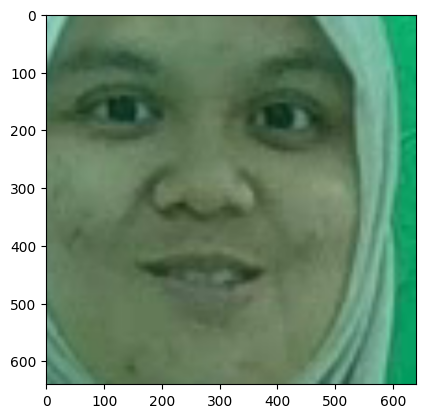

In [61]:
im = cv2.imread('gg.png')
plt.imshow(im)

# Taher Funcs

## Taher Imports

In [62]:

import cv2
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from colour import Color
import easydict
from IPython.display import clear_output
import mediapipe as mp

import torch.nn as nn
import torch
import math

import os 
from numpy.lib.function_base import average

## Taher Model

In [63]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

def model_static(pretrained=False, **kwargs):
    eyecontact_model = ResNet([3, 4, 6, 3], **kwargs)
    if pretrained:
        print ('loading saved eyecontact_model weights')
        model_dict = eyecontact_model.state_dict()
        snapshot = torch.load(f = pretrained, map_location=torch.device('cuda'))
        snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
        model_dict.update(snapshot)
        eyecontact_model.load_state_dict(model_dict)
    return eyecontact_model


class ResNet(nn.Module):
    def __init__(self, layers):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride = 1)
        self.fc_theta = nn.Linear(512 * Bottleneck.expansion, 34)
        self.fc_phi = nn.Linear(512 * Bottleneck.expansion, 34)
        self.fc_ec = nn.Linear(512 * Bottleneck.expansion, 1)
        self.init_param()

    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.shape[0] * m.weight.shape[1]
                m.weight.data.normal_(0, math.sqrt(2./n))
                m.bias.data.zero_()

    def _make_layer(self, planes, blocks, stride = 1):
        downsample = None
        layers = []

        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
                )

        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for i in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_ec(x)

        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


## load Model Weights

In [91]:
model_weight = '../eye-contact/data/model_weights.pkl'
device = torch.device('cpu')

# set up data transformation
test_transforms = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# load eyecontact_model weights
eyecontact_model = model_static()
model_dict = eyecontact_model.state_dict()
snapshot = torch.load(model_weight, map_location= device)
# snapshot = torch.load(model_weight)
model_dict.update(snapshot)
eyecontact_model.load_state_dict(model_dict)

eyecontact_model.train(False)


# # load eyecontact_model weights
# eyecontact_model = model_static()

# model_dict = eyecontact_model.load_state_dict(torch.load(model_weight, map_location= device ))
# # snapshot = torch.load_state_dict(model_weight, map_location=torch.device('cpu'))

# eyecontact_model.train = False

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [94]:
image = Image.open('mirror11.jpg')

In [95]:
torch_img = test_transforms(image)
torch_img.unsqueeze_(0)
eyecontact_output = eyecontact_model(torch_img)

eyecontact_score = F.sigmoid(eyecontact_output).item()  

print(eyecontact_score)

eyecontact_Pred = 1 if eyecontact_score>=0.9 else 0

0.9504226446151733


# MAIN

In [96]:
code = ['Frustration', 'Delight', 'Boredom', 'Confusion', 'Engaged']
def pipeline_with_kalman(i,path_A):
    path_A_ = path_A.split("/")
    key = path_A_[-1].split(".")[-2].split("-")[-1]+" "+path_A_[-2].split("-")[-1]
    print(i," : ",key)
    ind = []
    freeRIGHT = []
    freeLEFT = []
    freeRIGHT_k = []
    freeLEFT_k = []
    freeRIGHT_nk = []
    freeLEFT_nk = []
    
    head_points_without_k = []
    elbo_points_without_k = []
    head_points_with_k = []
    elbo_points_with_k = []
    head_points = []
    elbo_points = []
    
    decistion_body_without_k = ""
    decistion_body_with_k = ""
    decistion_body = ""
    decistion_hand_without_k = ""
    decistion_hand_with_k = ""
    decistion_hand = ""
    
    HFrameLable_kalman['without_kalman'][key] = []
    HFrameLable_kalman['with_kalman'][key] = []
    HFrameLable_kalman['Hybrid'][key] = []
    
    MFrameLable_kalman['without_kalman'][key] = []
    MFrameLable_kalman['with_kalman'][key] = []
    MFrameLable_kalman['Hybrid'][key] = []
    
    points_in_frames = []
    point_list = []
    index = 0 
    mp_pose = mp.solutions.pose 
    cap = cv2.VideoCapture(path_A)
    if (cap.isOpened() == False): 
        print("Error reading video file")
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    size = (frame_width, frame_height)
    frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    seconds = round(frames / fps)
    video_time = datetime.timedelta(seconds=seconds)
    delta_t = 1/fps
    A,P,H,R,Q,X = creat_kalman_parameters(delta_t)
    temp_1 = 0
    temp_2 = 0
    temp_3 = 0

    
    with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if (not ret) or (cv2.waitKey(10)==ord('q')):
                break
            image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            

            # Emotion Recognition
            xmin ,ymin, w, h = face_location(image)
            
            im = crop_face(image,xmin,ymin,w,h)

            predicted_idx = predict_sample(im)  

            # Eye-contact Detection
            torch_img = Image.fromarray(im)
            torch_img = test_transforms(torch_img)
            torch_img.unsqueeze_(0)
            eyecontact_output = eyecontact_model(torch_img)

            eyecontact_score = F.sigmoid(eyecontact_output).item()  
            
            print(eyecontact_score)

            eyecontact_Pred = 1 if eyecontact_score>=0.9 else 0
            
            eyecontact_string =  "Eyecontact" if eyecontact_Pred else "No Eyecontact"
            # print(eyecontact_string)
            # Pose Estimation
            results = pose.process(image)            
            

            image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
            try:
                landmarks = results.pose_landmarks.landmark
                points_in_frames.append(landmarks)
                point_list = filtter_points(points_in_frames[index])
                
                if index==1:
                    X = point_list
                for i in range(len(point_list)):
                    Z = point_list[i]
                    X[i] , P = Prediction_update(X[i],A,P,Q)
                    X[i] , P , K = Measurement_update(Z,X[i],P,H,R)
                
                # decistion_body_without_k,Ndecistion_body_without_k = body(point_list,head_points_without_k,elbo_points_without_k,temp_1,index)
                # decistion_body_with_k,Ndecistion_body_with_k = body(X,head_points_with_k,elbo_points_with_k,temp_2,index)
                #################
                if (len(point_list)==7):
                    decistion_body,Ndecistion_body = body(point_list,head_points,elbo_points,temp_3,index)
                else:
                    decistion_body,Ndecistion_body = body(X,head_points,elbo_points)
                
                # MFrameLable_kalman["without_kalman"][key].append(Ndecistion_body_without_k)
                # MFrameLable_kalman["with_kalman"][key].append(Ndecistion_body_with_k)
                MFrameLable_kalman["Hybrid"][key].append(Ndecistion_body)
                
                # decistion_hand_without_k,Ndecistion_hand_without_k = hand(point_list,freeLEFT_nk,freeRIGHT_nk)
                # decistion_hand_with_k,Ndecistion_hand_with_k = hand(X,freeLEFT_k,freeRIGHT_k)
                
                ########
                if (len(point_list)==7):
                    decistion_hand,Ndecistion_hand = hand(point_list,freeLEFT,freeRIGHT)
                else:
                    decistion_hand,Ndecistion_hand = hand(X,freeLEFT,freeRIGHT)
                    
                # HFrameLable_kalman['without_kalman'][key].append(Ndecistion_hand_without_k)
                # HFrameLable_kalman['with_kalman'][key].append(Ndecistion_hand_with_k)
                HFrameLable_kalman['Hybrid'][key].append(Ndecistion_hand)
                
                ind.append(index)
                index+=1
            except:
                pass
            
            cv2.putText(image,decistion_hand,(0,25),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            cv2.putText(image,decistion_body,(0,60),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            
            cv2.putText(image,classes[predicted_idx],(0,95),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            cv2.putText(image,eyecontact_string,(0,130),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            
            # cv2.putText(image,decistion_hand+" : Hybrid",(0,165),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            # cv2.putText(image,decistion_body+" : Hybrid",(0,200),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            decistion_hand_without_k = ''
            decistion_body_without_k = ''
            
            decistion_hand_with_k =''
            decistion_body_with_k = ''
            
            decistion_hand = ''
            decistion_body = ''
#             Drawing_utils(image,results,mp_pose)
            cv2.imshow('Body Movement Taske',image)


            if cv2.waitKey(10)==ord('q'):
                break
    indall.append(ind)
    cap.release()
    cv2.destroyAllWindows()

In [98]:
path_folder = '../Presenter No1-Asylah/C_presenter No1-groupA.mp4'
# folders ,videos = get_videos(path_folder)
HFrameLable_kalman = {}
HFrameLable_kalman['without_kalman'] = {}
HFrameLable_kalman['with_kalman'] = {}
HFrameLable_kalman['Hybrid'] = {}


MFrameLable_kalman = {}
MFrameLable_kalman['without_kalman'] = {}
MFrameLable_kalman['with_kalman'] = {}
MFrameLable_kalman['Hybrid'] = {}
indall = []
# folders , all_video_paths = get_videos(path_folder)
# for j,i in enumerate([all_video_paths[3],all_video_paths[5],all_video_paths[15],all_video_paths[18],all_video_paths[20],all_video_paths[22]]):
#     try:
#         pipeline_with_kalman(j,i)
#     except:
pipeline_with_kalman(0,path_folder)

0  :  groupA Asylah
0.3304279148578644
0.326351523399353
0.32652804255485535
0.3658868074417114
0.3989854156970978
0.46813592314720154
0.5722755193710327
0.696153998374939
0.8276721835136414
0.9431977272033691
0.9550668597221375
0.929365873336792
0.9914366602897644
0.994143545627594
0.9818868637084961
0.9739004969596863
0.961682140827179
0.9111279845237732
0.9710404872894287
0.9287495613098145
0.9272856712341309
0.9120416641235352
0.9074617028236389
0.8458588719367981
0.844109833240509
0.9257075190544128
0.8138184547424316
0.9167859554290771
0.8218349814414978
0.6635549068450928
0.688446044921875
0.7754979729652405
0.688832700252533
0.9255128502845764
0.9360670447349548
0.9798769354820251
0.9817325472831726
0.983617901802063
0.9868084788322449
0.9817588329315186
0.9860608577728271
0.9908067584037781
0.9867051243782043
0.9940875768661499
0.9919453263282776
0.9961835741996765
0.9970768690109253
0.9947353005409241
0.996493399143219
0.9961572289466858
0.996468186378479
0.9962502121925354
0

In [ ]:
# save_object(HFrameLable_kalman,"HFrameLable_kalman")
# save_object(MFrameLable_kalman,"MFrameLable_kalman")
# save_object(indall,"indall")
HFrameLable_kalman = load_object('HFrameLable_kalman')
MFrameLable_kalman = load_object('MFrameLable_kalman')

In [ ]:
def grouping_frames(X_List,Type):
    temp = []
    t = []
    for i,x in enumerate(X_List):
        t.append(x)
        if len(t)%15==0:
            X = sum(t)
            if Type=="hand":
                if X>=5:
                    temp.append(1)
                else:
                    temp.append(0)
            if Type=="body":
                if X>=3:
                    temp.append(1)
                else:
                    temp.append(0)
            t = [] 
    return temp

In [ ]:
def video_calss(hand_list,body_list):
    number_hand_positive = sum(hand_list)
    all_hand_frames = len(hand_list)
    hand_score = 0.65*(number_hand_positive/all_hand_frames)
    
    number_body_positive = sum(body_list)
    all_body_frames = len(body_list)
    body_score = 0.35*(number_body_positive/all_body_frames)
    
    final_score = hand_score+body_score
#     print(final_score)
    return 1 if final_score>0.35 else 0

In [ ]:
print("______________________________Hand Moveing______________________________")
hand = []
move = []
for Type in HFrameLable_kalman:
    print(Type,".......\n")
    for name in HFrameLable_kalman[Type]:
        print(name,":")
        hand.append(grouping_frames(HFrameLable_kalman[Type][name],'hand'))
        print("number of frame : ",len(HFrameLable_kalman[Type][name]))
        print("number of positive : ",sum(HFrameLable_kalman[Type][name]))
        print("number of negative : ",len(HFrameLable_kalman[Type][name])-sum(HFrameLable_kalman[Type][name]))
        print("average of positive : ",sum(HFrameLable_kalman[Type][name])/len(HFrameLable_kalman[Type][name]))
        print("average of negative : ",(len(HFrameLable_kalman[Type][name])-sum(HFrameLable_kalman[Type][name]))/len(HFrameLable_kalman[Type][name]))
        print("============================================================================================")
print("\n############################################################################################\n")
print("______________________________Body Moveing______________________________")        
for Type in MFrameLable_kalman:
    print(Type,".......\n")
    for name in MFrameLable_kalman[Type]:
        print(name,":\n")
        move.append(grouping_frames(MFrameLable_kalman[Type][name],'body'))
        print("number of frame : ",len(MFrameLable_kalman[Type][name]))
        print("number of positive : ",sum(MFrameLable_kalman[Type][name]))
        print("number of negative : ",len(MFrameLable_kalman[Type][name])-sum(MFrameLable_kalman[Type][name]))
        print("average of positive : ",sum(MFrameLable_kalman[Type][name])/len(MFrameLable_kalman[Type][name]))
        print("average of negative : ",(len(MFrameLable_kalman[Type][name])-sum(MFrameLable_kalman[Type][name]))/len(MFrameLable_kalman[Type][name]))
        print("============================================================================================")
save_object(hand,"hand")
save_object(move,"move")

______________________________Hand Moveing______________________________
without_kalman .......

 TEDxHHL BODY MOV :
number of frame :  8502
number of positive :  1355
number of negative :  7147
average of positive :  0.15937426487885203
average of negative :  0.8406257351211479
 TEDxBlumenau part 2 BODY MOV :
number of frame :  7790
number of positive :  1394
number of negative :  6396
average of positive :  0.17894736842105263
average of negative :  0.8210526315789474
GroupA Rafeef :
number of frame :  2932
number of positive :  718
number of negative :  2214
average of positive :  0.24488403819918145
average of negative :  0.7551159618008185
GroupD Rafeef :
number of frame :  3007
number of positive :  0
number of negative :  3007
average of positive :  0.0
average of negative :  1.0
GroupB Aqail :
number of frame :  2987
number of positive :  204
number of negative :  2783
average of positive :  0.06829594911282223
average of negative :  0.9317040508871778
GroupD Aqail :
number of 

In [ ]:
# load_object('hand')
# load_object('move')

In [ ]:
for y,i in enumerate(hand):
    if y%6==0:
        print("=================")
    print(str(sum(i))+"/"+str(len(i)))

118/566
135/519
76/195
0/200
7/199
0/201
108/566
124/519
69/195
0/200
8/199
0/201
118/566
135/519
76/195
0/200
7/199
0/201


In [ ]:
for i in range(len(hand)):
    if i%6==0:
        print("=================")
    print(video_calss(hand[i],move[i]))

1
1
1
0
1
0
1
1
1
0
1
0
1
1
1
0
1
0
